# Spectral estimation

Given a time series 

\begin{equation}
    x(n)
\end{equation}

with fft spectrum

\begin{equation}
    y(m) = \sum_{n=0}^{N-1}x(n) \exp\{-2\pi i\frac{nm}{N}\}
\end{equation}

or

\begin{equation}
    y(m) = FFT(x(n))
\end{equation}


Power spectrum is defined as

\begin{equation}
    P(m) = |y(m)|^2
\end{equation}

Power spectral density (PSD) of a discrete-time noise signal is given by the FFT of its autocorrelation function, R(k)

\begin{equation}
    PSD(m) = FFT(R(k))
\end{equation}

where the autocorrelation function R(k) is defined as

\begin{equation}
    R(k)=\frac{1}{N}\sum_{n=0}^{N-1}x(n)x(n-k)
\end{equation}

that is

\begin{equation}
    PSD(m) = \sum_{k=0}^{N-1}\frac{1}{N}\sum_{n=0}^{N-1}x(n)x(n-k) \exp\{-2\pi i\frac{km}{N}\}
\end{equation}

\begin{equation}
    PSD(m) = \frac{1}{N}\sum_{n=0}^{N-1}x(n)\exp\{-2\pi i\frac{nm}{N} \} \sum_{k=0}^{N-1}x(n-k) \exp\{2\pi i\frac{(n-k)m}{N}\}
\end{equation}

\begin{equation}
    PSD(m) = \frac{1}{N}|FFT(x(n))|^2
\end{equation}

or

\begin{equation}
    PSD(m) = \frac{1}{N} P(m)
\end{equation}

While the PSD is related to the Power Spectrum by dividing by length of FFT (i.e. length of signal window), the proper estimation of the Autocorrelation funtion $R(k)$ requires a signal length that is typically longer than the FFT, which cannot be done for short signals (transients), even if mathematically possible, but estimate is not reliable.

### 1/Hz density estimate
Above PSD is on a per sample bases. Concerning the 1/Hz density estimate one has to scale the estimate by the number of samples per second.

\begin{equation}
    PSD(m) = \frac{1}{fs N} P(m)
\end{equation}
where $fs$ is the sampling frequency

### Windowed PSD estimates 
When windowing the timeseries before PSD estimates

\begin{equation}
    PSD(m) = \frac{1}{fs \sum{w(n)^2}} |FFT(w(n)x(n))|^2
\end{equation}

For a rectangular window we have $\sum{w(n)^2}=N$ 

### Windowed power spectrum estimates 
Alternatively to the PSD we have the power spectrum

\begin{equation}
    PS(m) = \frac{1}{(\sum{w(n)})^2} |FFT(w(n)x(n))|^2
\end{equation}
that allows the RMS spectral estimates of tonal signals, but provides wrong results for random signals


## Welch PSD

In the following, some Python should demonstrate the different  

### Startup and helper functions.

There are two functions defined
- mSpectrum: direct FFT based power spectral estimate
- wSpectrum: Welch based estimation (for comparison as well defind method) 
- estSpectrum: spectrum estimation and plotting function

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig

def mSpectrum(xx,win,fs):
    # estimate power spectral density (PSD) usinf rfft directly
    nwin=len(win)
    nfft=nwin
    yy=np.fft.rfft(xx[:nwin]*win,nfft)
    pp=np.abs(yy)**2
    pp[1:] *=2                  # compensate for negatice frequencies
    ff=np.arange(int(nfft/2)+1)*fs/nfft
    sc1= fs * (win*win).sum()  # for density
    sc2= win.sum()**2          # for spectrum
    return ff,pp/sc1,pp/sc2

def wSpectrum(xx,win,fs):
    # estimate power spectral density (PSD)
    f, Pxx_dens = sig.welch(xx, fs=fs, nperseg=len(win), noverlap=0, scaling="density", window=win)
    # estimate power spectrum
    f, Pxx_spec = sig.welch(xx, fs=fs, nperseg=len(win), noverlap=0, scaling="spectrum", window=win)
    return f,Pxx_dens,Pxx_spec


def estSpectrums(time,xx,win,fs,amp):
    f,Pxx_dens,Pxx_spec=mSpectrum(xx,win,fs)
    #
    print("'Spect' peak (RMS): ",np.sqrt(Pxx_spec.max()))
    #
    fig = plt.figure("figure.figsize",[15,10])

    plt.subplot(211)
    plt.plot(time,xx)
    plt.plot(time,amp+0*time,'r')
    plt.xlim(0.4,0.6)

    plt.subplot(223)
    plt.semilogy(f/1000, Pxx_dens)
    plt.ylim(1e-4,np.max(np.floor(amp)*20))
    plt.xlabel('Frequency [kHz]')
    plt.ylabel('PSD [V**2/Hz]')
    plt.grid(True)

    plt.subplot(224)
    plt.semilogy(f/1000, Pxx_spec)
    plt.ylim(1e-4,np.max(np.floor(amp)*20))
    plt.xlabel('Frequency [kHz]')
    plt.ylabel('Spectrum [V**2]')
    plt.grid(True)



## Tonal + Noise
The sampling frequency, signal and window length are chosen such that the Welch PSD corresponds to a single FFT transform. For longer signals the Welch PSD estimates would only average the spectra.

From the graphs one notes that the noise level (0.001) is estimated by the PSD (density) method, while the signal RMS (10 units) estimate corresponds to the peak value of the Spectrum (not density) estimate, but the noise density is then wrongly estimated. 

The examples are derived from the Python Welch documentation and are consequently only valid in the python environment. 

Signal RMS :  10.0 9.999999999999996
'Spect' peak (RMS):  10.001278815967018


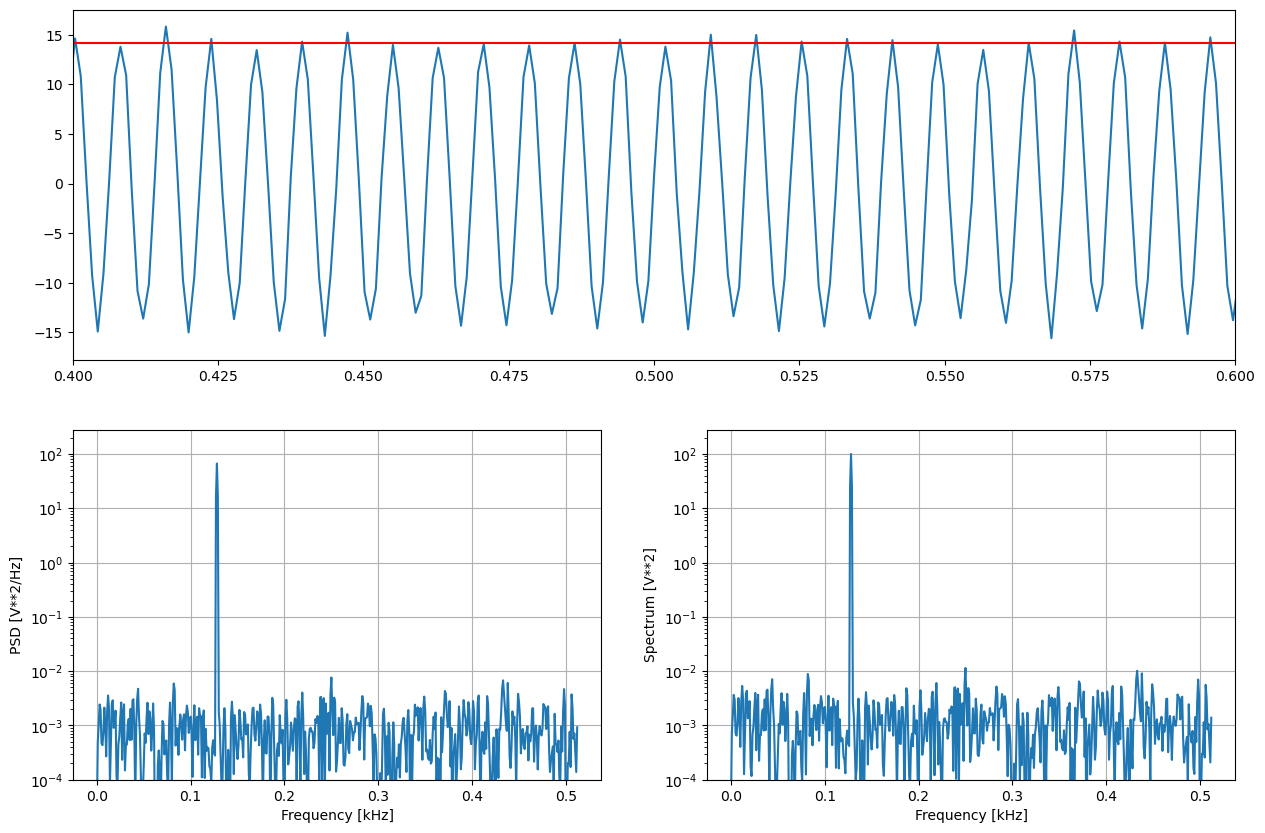

In [2]:
fs = 1024   #Hz
nwin=fs
nfft=nwin

#    Generate a 1 second test signal, a 2 Vrms sine wave at fs/8, corrupted by
#    0.001 V**2/Hz of white noise sampled at  1.024 kHz.

N = fs
time = np.arange(N) / fs

amp = 10*np.sqrt(2)
freq = fs/8
noise_power = 0.001 * fs / 2 
# The factor of fs/2 converts the per sample noise power (variance) to a noise bandwith of -1/T to 1/T (negative and positive freqtencies) 

xx = amp*np.sin(2*np.pi*freq*time)
rms= np.sqrt(np.mean(xx**2))
xx += np.random.normal(scale=np.sqrt(noise_power), size=time.shape)

print("Signal RMS : ",amp/np.sqrt(2), rms)

# obtain window
win=sig.get_window("hann",nwin)

estSpectrums(time,xx,win,fs,amp)


### Transient + noise

Assume short transient (echolocation click) in the middle of the time window 

The transient is sinusoidal with a bell shaped (gaussian) amplitude function.

We can see from the pictures that the noise density is correctly estimated by the PSD (density) method, but both the density and the spectrum method cannot provide a good description of the transient. The signal is to short for RMS estimation. Signal characteristics can only be estimated after signal detection, when the background noise is elimiated.

Signal peak and energy :  10.0 708.9815403622064
'Spect' peak (RMS):  0.3395521973900811


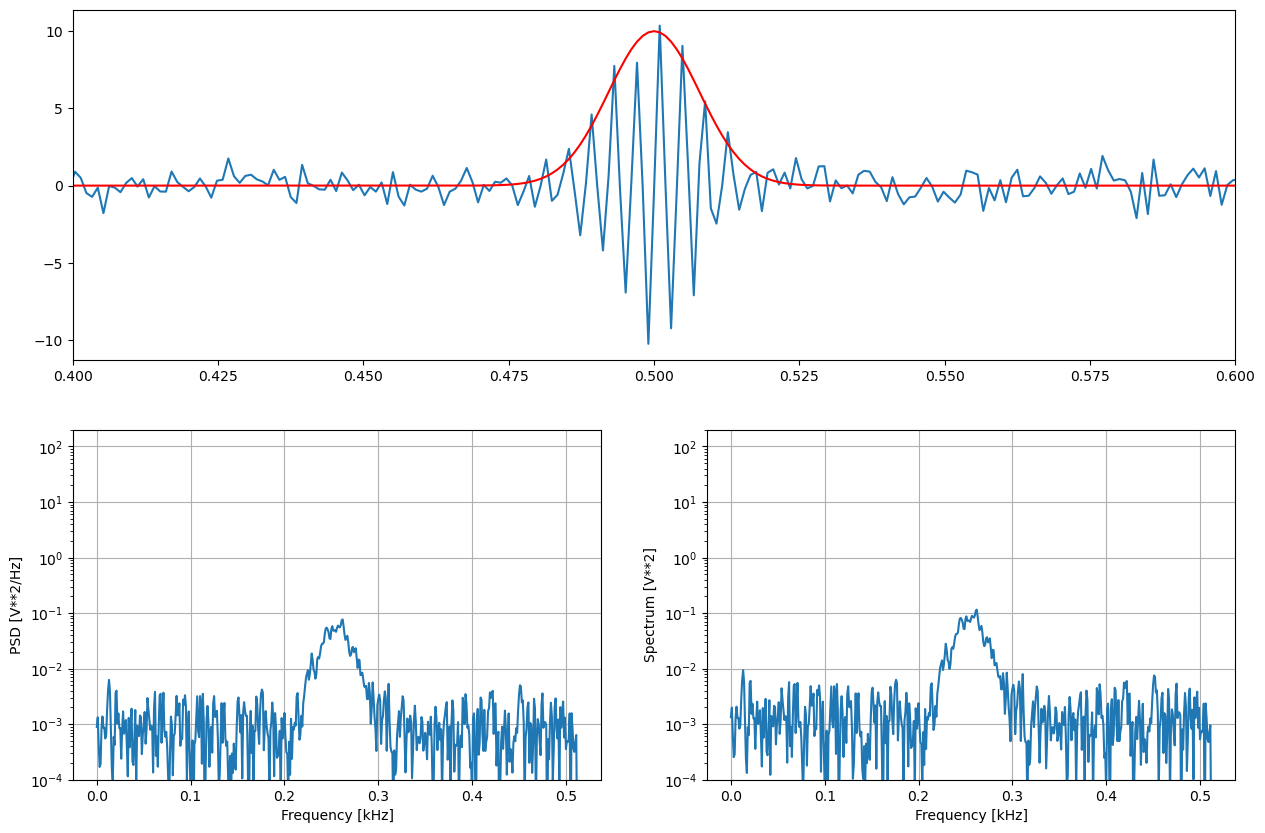

In [3]:
fs = 1024   #Hz
nwin=fs
nfft=nwin

#    Generate a 1 second test signal, a 10 VPeak Gaussian shaped sine wave at fs/4, corrupted by
#    0.001 V**2/Hz of white noise sampled at  1.024 kHz.

N = fs
time = np.arange(N) / fs

sigma=8/N
amp=10*np.exp(-1/2*((time-time[N//2])/sigma)**2)

freq = fs/4
noise_power = 0.001 * fs / 2 
xx = amp*np.sin(2*np.pi*freq*time) 
energy= np.sum(xx**2)
xx += np.random.normal(scale=np.sqrt(noise_power), size=time.shape)

print("Signal peak and energy : ",amp.max(), energy)

# obtain window
win=sig.get_window("hann",nwin)

estSpectrums(time,xx,win,fs,amp)


Signal peak and energy :  10.0 708.9815403622064
'Spect' peak (RMS):  0.3386880816197741


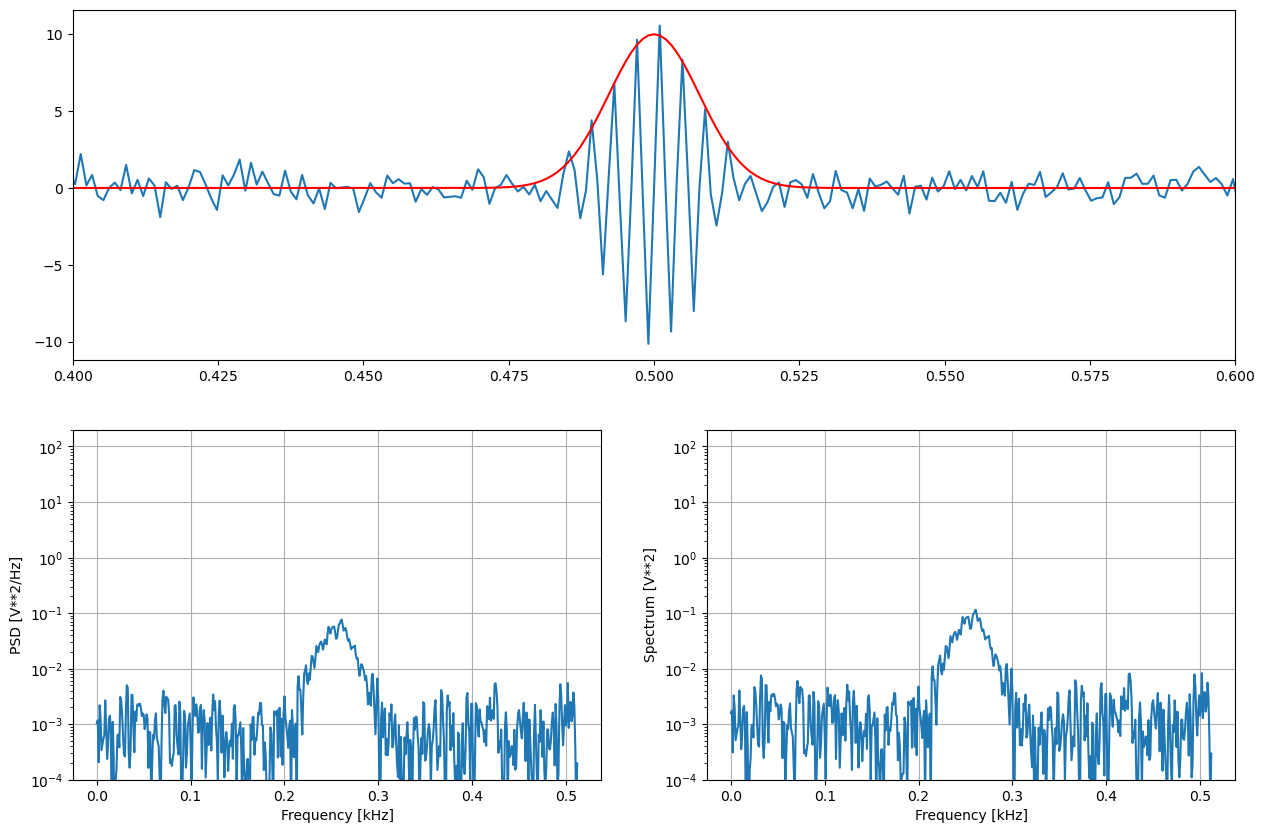

In [4]:
fs = 1024   #Hz
nwin=fs
nfft=nwin

#    Generate a 1 second test signal, a 10 VPeak Gaussian shaped sine wave at fs/4, corrupted by
#    0.001 V**2/Hz of white noise sampled at  1.024 kHz.

N = fs
time = np.arange(N) / fs

sigma=8/N
amp=10*np.exp(-1/2*((time-time[N//2])/sigma)**2)

freq = fs/4
noise_power = 0.001 * fs / 2 
xx = amp*np.sin(2*np.pi*freq*time) 
energy= np.sum(xx**2)
xx += np.random.normal(scale=np.sqrt(noise_power), size=time.shape)

print("Signal peak and energy : ",amp.max(), energy)

# obtain window
win=sig.get_window("hann",nwin)

estSpectrums(time,xx,win,fs,amp)


This examples shows that when window or FFT length is much longer than signal, the contamination of noise is significant and does not allow a reliable spectral description of the the signal.

### Estimmation of transient peak amplitude

After shown that both metrics V^2/Hz and RMS make no sense for tansients and therefore echolcation clicks, the question arizes how to scale the spectrum in order to relate the numbers to the time series.

First we note that the signal is smaller than the analysis window so we need to remove contributions from outside the signal from the spectrum. This can done by either a rectangular that is result of the signal detection. In the following a gaussian window is used.

In [5]:
win=amp/amp.max()
yy=np.abs(np.fft.rfft(xx*win))**2
yy[1:] *=2
print(yy.max()/N)


10.378479996686465


We see that scaling the power spectrum by fft length one normalizes the click spectrum to the peak anplitude.

## Summary
the above examples show that for different type of signals one uses different characteristic measurements resulting in different algorithms

### noise spectral density
Scale FFT power estimate with $1/(f_s \sum w^2[n])$ to obtain power/Hz
### tonals RMS estimates
Scale FFT peak power estimate with $1/(\sum w[n])^2$ to obtain signal rms estimate
### transient peak estimates
Scale FFT peak power estimate with $1/N$ to obtain signal peak amplitude
